# Classification fine-tuning using Helical

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/helicalAI/helical/blob/main/examples/notebooks/Cell-Type-Classification-Fine-Tuning.ipynb)

## Cell type classification task

In [1]:
from helical.utils import get_anndata_from_hf_dataset
from helical.models.geneformer import GeneformerConfig, GeneformerFineTuningModel
from helical.models.scgpt import scGPTConfig, scGPTFineTuningModel
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import logging, warnings
import umap
import pandas as pd
import seaborn as sns

logging.getLogger().setLevel(logging.ERROR)

warnings.filterwarnings("ignore")

INFO:datasets:PyTorch version 2.3.0 available.
INFO:datasets:Polars version 0.20.31 available.
INFO:datasets:JAX version 0.4.31 available.


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Install datasets

In [3]:
from datasets import load_dataset
ds = load_dataset("helical-ai/yolksac_human",trust_remote_code=True, download_mode="reuse_cache_if_exists")

Generating test split: 100%|██████████| 6336/6336 [00:02<00:00, 2127.91 examples/s]


In [4]:
train_dataset = get_anndata_from_hf_dataset(ds["train"])
test_dataset = get_anndata_from_hf_dataset(ds["test"])

## Prepare training labels

- For this classification task we want to predict cell type classes
- So we save the cell types as a list

In [5]:
cell_types_train = list(np.array(train_dataset.obs["LVL1"].tolist()))
cell_types_test = list(np.array(test_dataset.obs["LVL1"].tolist()))

- We convert these string labels into unique integer classes for training

In [6]:
label_set = set(cell_types_train) | set(cell_types_test)
class_id_dict = dict(zip(label_set, [i for i in range(len(label_set))]))
id_class_dict = {v: k for k, v in class_id_dict.items()}

for i in range(len(cell_types_train)):
    cell_types_train[i] = class_id_dict[cell_types_train[i]]

for i in range(len(cell_types_test)):
    cell_types_test[i] = class_id_dict[cell_types_test[i]]



## Geneformer Fine-Tuning

- Choose the desired configs
- Define the Geneformer Fine-Tuning Model from the Helical package which appends a fine-tuning head automatically from the list of available heads
- Define the task type, which in this case is classification
- Defined the output size, which is the number of unique labels for classification

In [7]:
geneformer_config = GeneformerConfig(device=device, batch_size=10, model_name="gf-6L-30M-i2048")
geneformer_fine_tune = GeneformerFineTuningModel(geneformer_config=geneformer_config, fine_tuning_head="classification", output_size=len(label_set))

Process the data so it is in the correct form for Geneformer

In [8]:
geneformer_train_dataset = geneformer_fine_tune.process_data(train_dataset)
geneformer_test_dataset = geneformer_fine_tune.process_data(test_dataset)

Map: 100%|██████████| 6336/6336 [00:04<00:00, 1529.05 examples/s]


Geneformer makes use of the Hugging Face dataset class and so we need to add the labels as a column to this dataset

In [9]:
geneformer_train_dataset = geneformer_train_dataset.add_column("LVL1", cell_types_train)
geneformer_test_dataset = geneformer_test_dataset.add_column("LVL1", cell_types_test)

Fine-tune the model

In [10]:
geneformer_fine_tune.train(train_dataset=geneformer_train_dataset.shuffle(), validation_dataset=geneformer_test_dataset, label="LVL1", freeze_layers=0, epochs=1, optimizer_params={"lr": 1e-4}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

Fine-Tuning:   0%|          | 0/2535 [00:00<?, ?it/s]

Fine-Tuning Validation: 100%|██████████| 634/634 [00:29<00:00, 21.64it/s, val_loss=0.0466]


### Get the outputs for the test set

In [11]:
outputs = geneformer_fine_tune.get_outputs(geneformer_test_dataset)

Generating Outputs: 100%|██████████| 634/634 [00:29<00:00, 21.68it/s]


### Get the embeddings from our fine-tuned model

In [12]:
embeddings = geneformer_fine_tune.get_embeddings(geneformer_test_dataset)

100%|██████████| 634/634 [00:50<00:00, 12.68it/s]


## We can now get the results of our model and visualise what has been learned

### Visualise the embeddings of the fine-tuned model

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

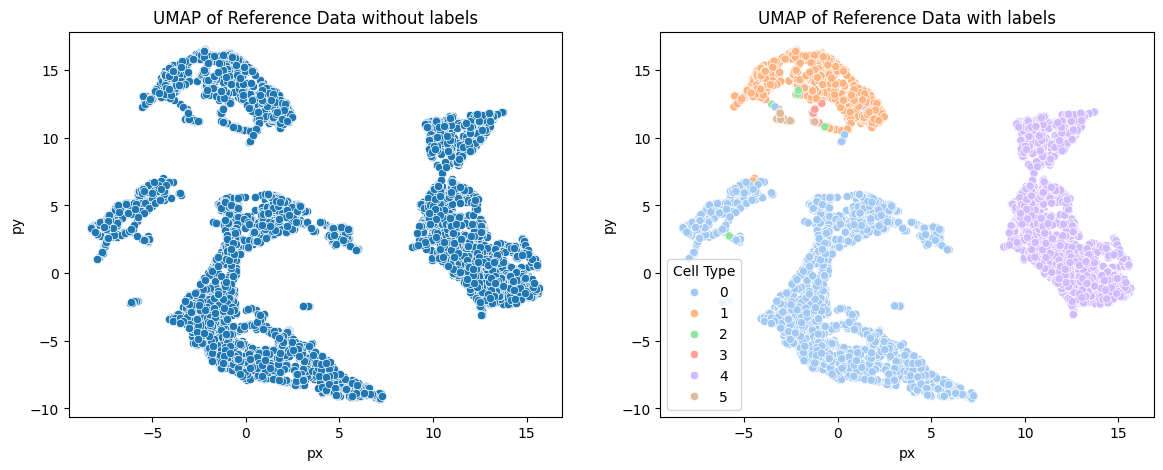

In [13]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None, n_neighbors=4)
mapper = reducer.fit(embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = geneformer_test_dataset["LVL1"]
plot_df['Cell Type'] = labels


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

### Print the classification report

In [14]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3001
           1       0.94      0.99      0.97       938
           2       0.27      0.53      0.36        19
           3       0.00      0.00      0.00        19
           4       1.00      1.00      1.00      2321
           5       0.94      0.84      0.89        38

    accuracy                           0.98      6336
   macro avg       0.69      0.72      0.70      6336
weighted avg       0.98      0.98      0.98      6336



### Plot the confusion matrix for the test dataset outputs vs true labels

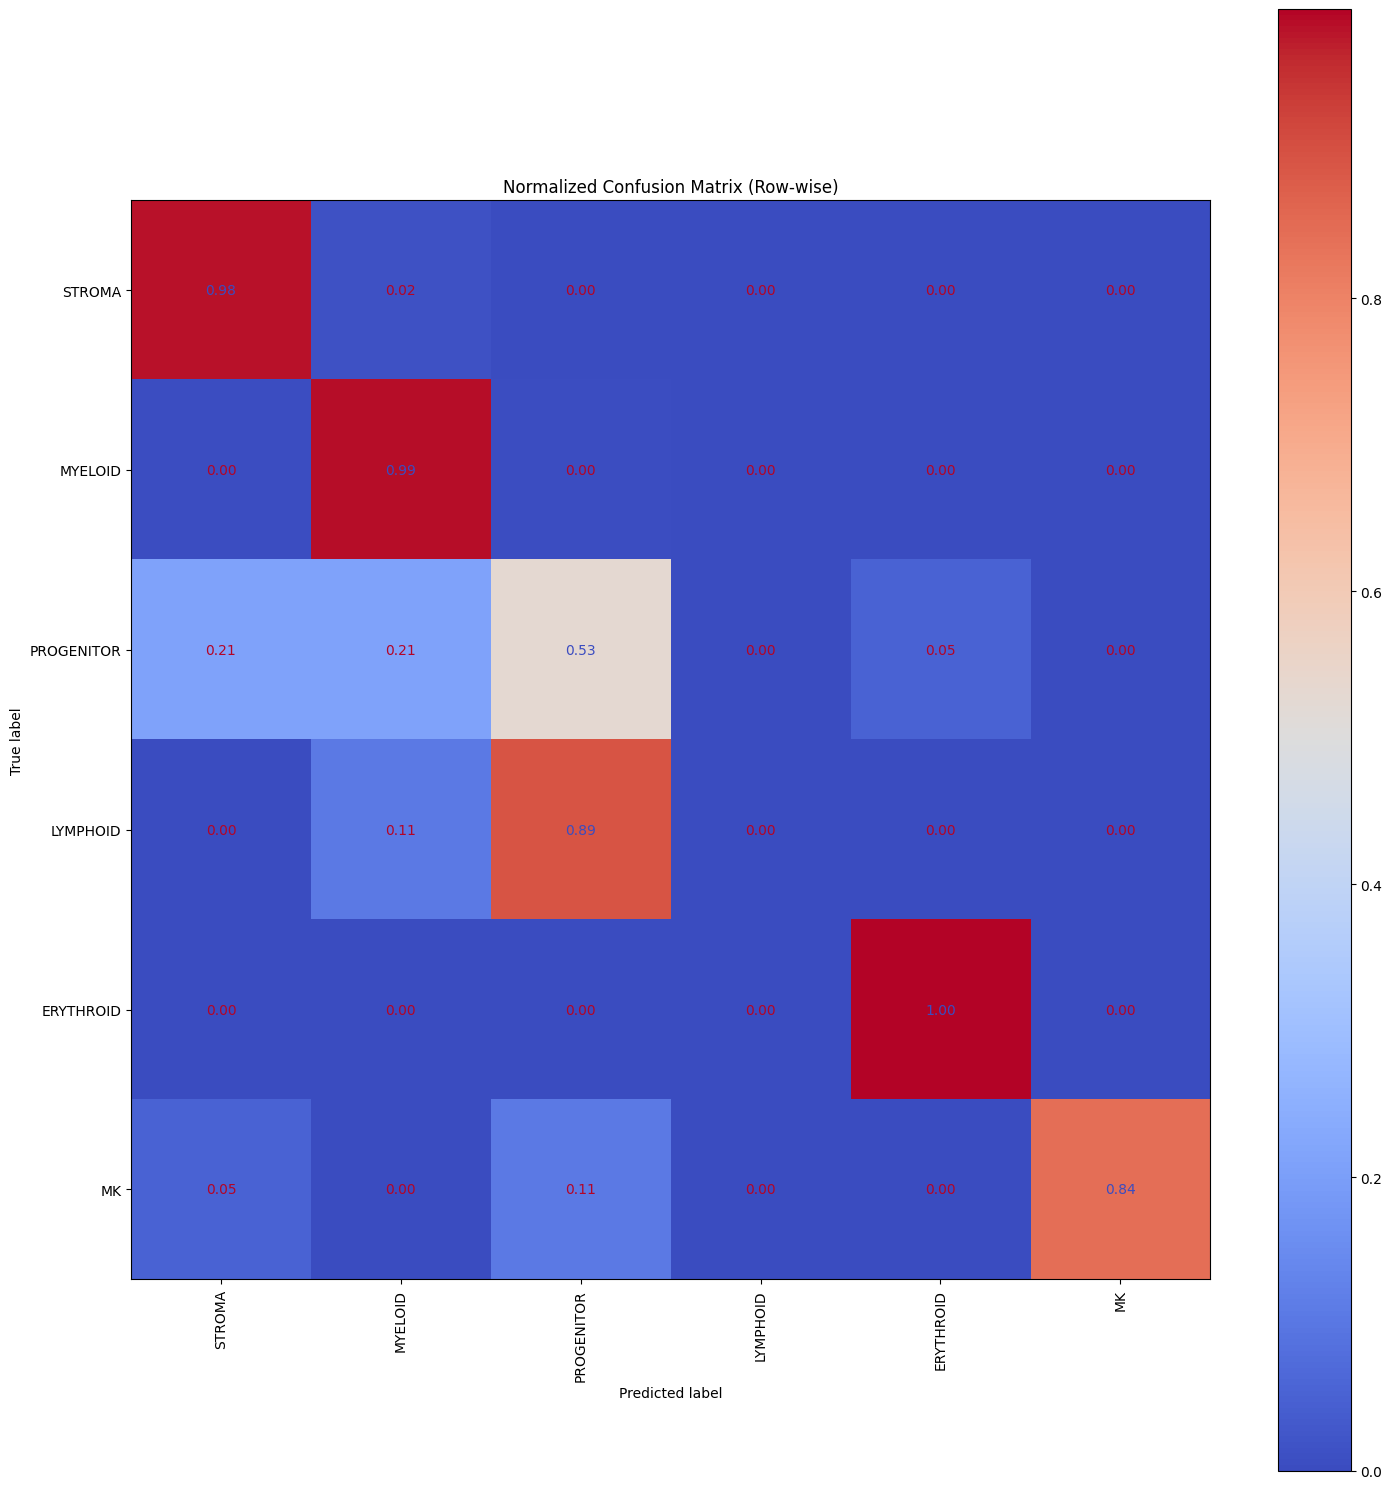

In [15]:
# Compute the confusion matrix
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()

## scGPT Fine-Tuning

Now the same procedure with scGPT
- Loading the fine-tuning model and setting desired configs

In [16]:
scgpt_config=scGPTConfig(batch_size=10, device=device)
scgpt_fine_tune = scGPTFineTuningModel(scGPT_config=scgpt_config, fine_tuning_head="classification", output_size=len(label_set))

A slightly different methodology for getting the dataset for scGPT since it does not make use of the Hugging Face Dataset class
- Split the data into a train and validation set

In [17]:
dataset = scgpt_fine_tune.process_data(train_dataset, gene_names = "gene_name")
validation_dataset = scgpt_fine_tune.process_data(test_dataset, gene_names = "gene_name")

For scGPT fine tuning we have to pass in the labels as a separate list
- This is the same for the validation and training sets

In [18]:
scgpt_fine_tune.train(train_input_data=dataset, train_labels=cell_types_train, validation_input_data=validation_dataset, validation_labels=cell_types_test, epochs=1, optimizer_params={"lr": 2e-5}, lr_scheduler_params={"name":"linear", "num_warmup_steps":0, 'num_training_steps':1})

Fine-Tuning Validation: 100%|██████████| 634/634 [00:39<00:00, 16.18it/s, val_loss=0.0302]


### Get the outputs for the test dataset

In [19]:
outputs = scgpt_fine_tune.get_outputs(validation_dataset)

Fine-Tuning Validation: 100%|██████████| 634/634 [00:36<00:00, 17.43it/s]


### Get the embeddings for the fine-tuned model

In [20]:
embeddings = scgpt_fine_tune.get_embeddings(validation_dataset)

Embedding cells: 100%|██████████| 634/634 [00:15<00:00, 39.98it/s]


## We can now get the results of our model and visualise what has been learned

### Visualise the embeddings of the fine-tuned model

Text(0.5, 1.0, 'UMAP of Reference Data with labels')

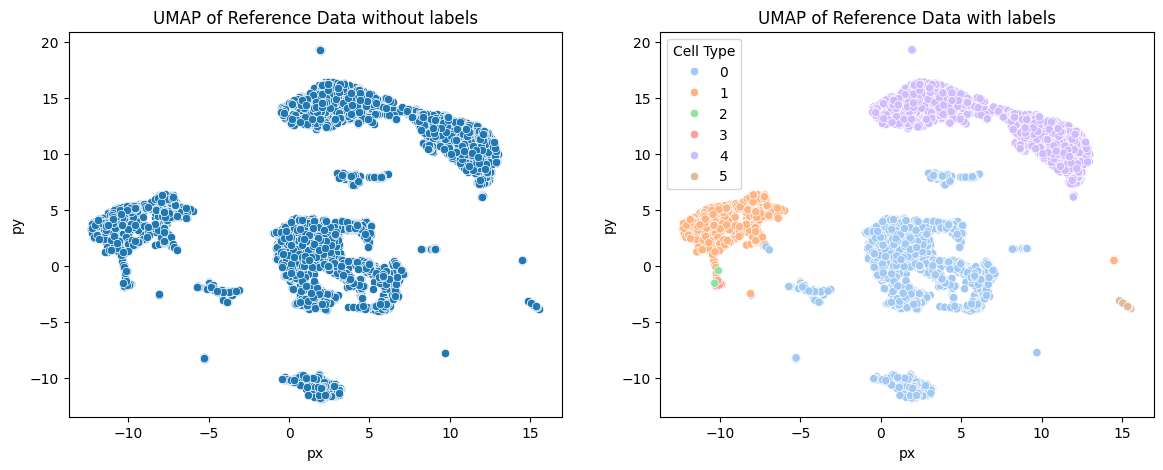

In [21]:
reducer = umap.UMAP(min_dist=0.2, n_components=2, n_epochs=None, n_neighbors=4)
mapper = reducer.fit(embeddings)

plot_df = pd.DataFrame(mapper.embedding_,columns=['px','py'])
labels = cell_types_test
plot_df['Cell Type'] = labels


# Create a matplotlib figure and axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

#plt.style.use("dark_background")

sns.scatterplot(data = plot_df,x='px',y='py',sizes=(50,200),ax=axs[0],palette="pastel")
axs[0].set_title('UMAP of Reference Data without labels')

sns.scatterplot(data = plot_df,x='px',y='py',hue='Cell Type',sizes=(50,200),ax=axs[1],palette="pastel")
axs[1].set_title('UMAP of Reference Data with labels')

### Print the classification report

In [22]:
print(classification_report(cell_types_test,outputs.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3001
           1       0.99      0.98      0.99       938
           2       0.62      0.26      0.37        19
           3       0.64      0.84      0.73        19
           4       1.00      1.00      1.00      2321
           5       0.82      0.97      0.89        38

    accuracy                           0.99      6336
   macro avg       0.85      0.84      0.83      6336
weighted avg       0.99      0.99      0.99      6336



### Plot the confusion matrix of the test outputs vs the true labels

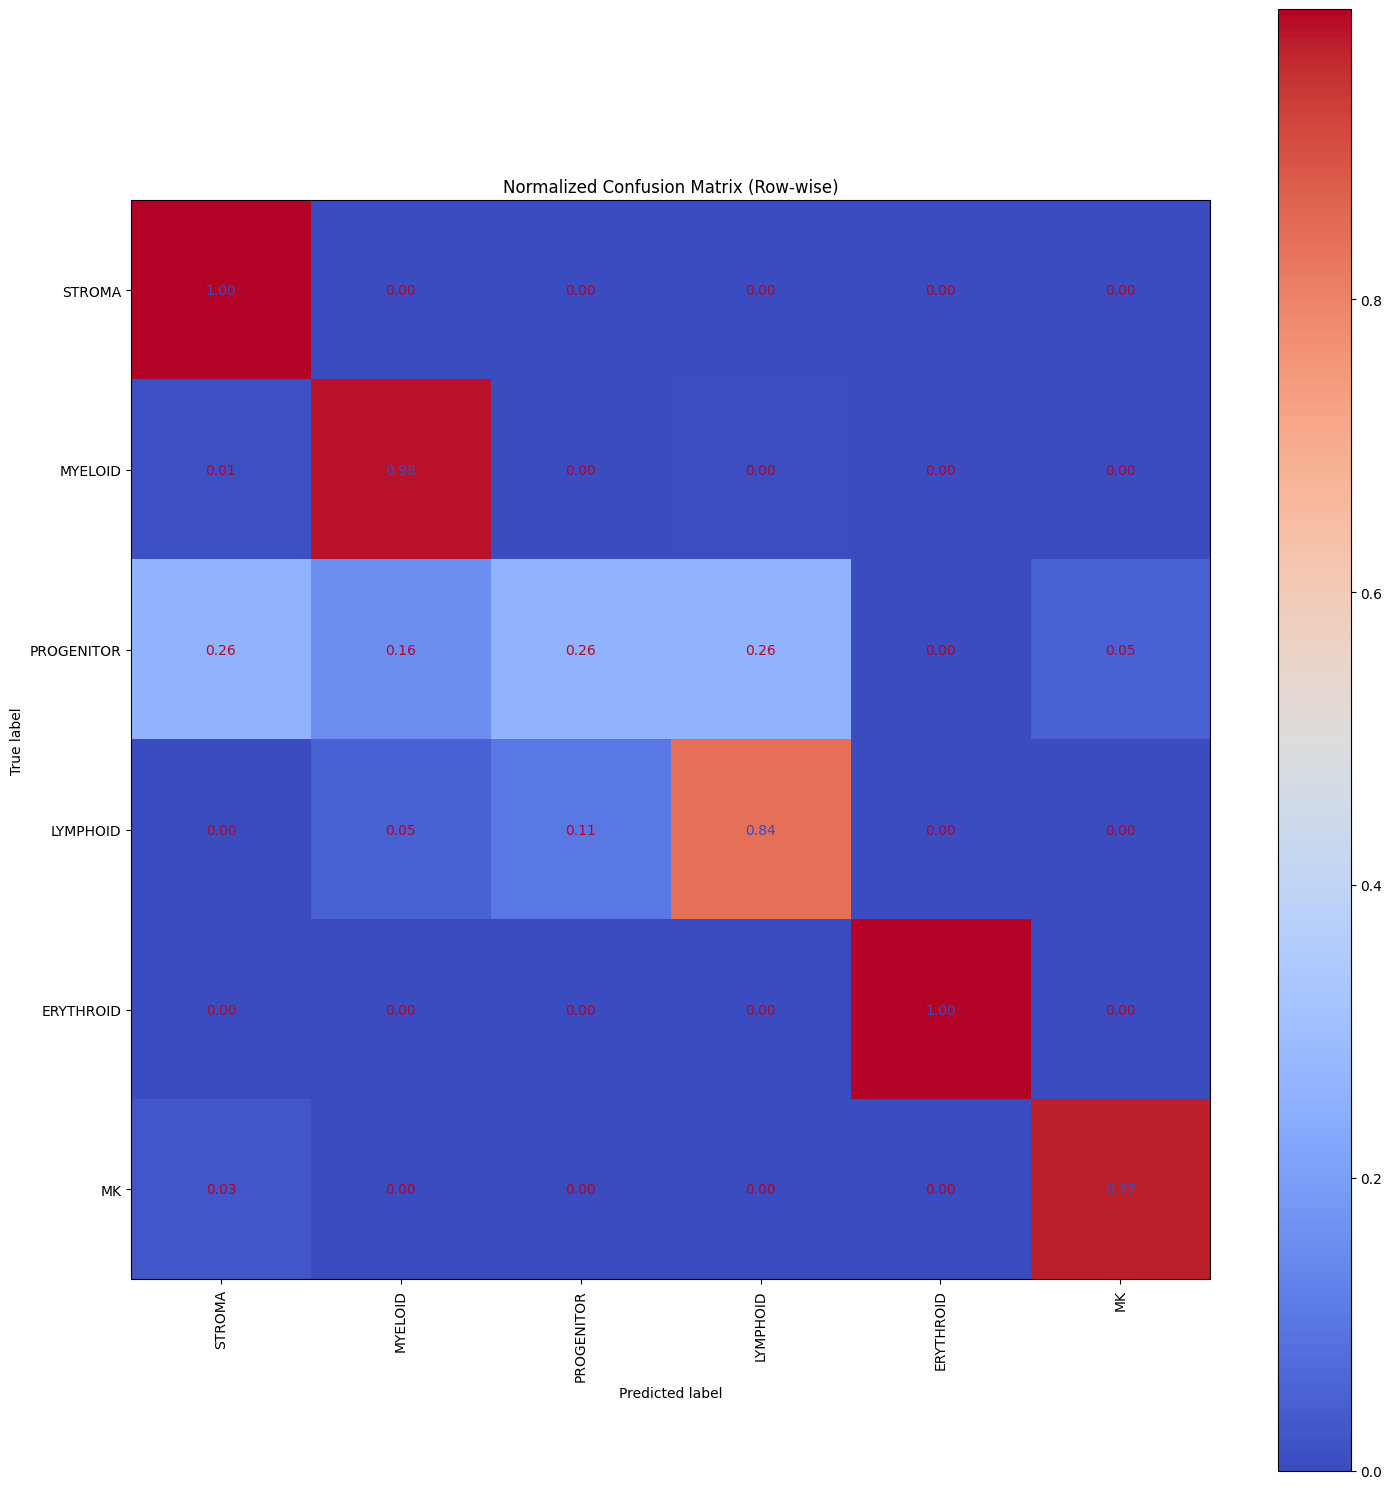

In [23]:
# Compute the confusion matrix
cm = confusion_matrix(cell_types_test, outputs.argmax(axis=1))

# Perform row-wise normalization
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Get unique labels in the order they appear in the confusion matrix
unique_labels = np.unique(np.concatenate((cell_types_test, outputs.argmax(axis=1))))

# Use id_class_dict to get the class names
class_names = [id_class_dict[label] for label in unique_labels]

# Create and plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp.plot(ax=ax, xticks_rotation='vertical', values_format='.2f', cmap='coolwarm')

# Customize the plot
ax.set_title('Normalized Confusion Matrix (Row-wise)')
fig.set_facecolor("none")

plt.tight_layout()
plt.show()
